In [1]:
import cv2
import torch
import pandas as pd
import numpy as np
import albumentations as A 
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import sys
sys.path.append('..')
from source.model import Model

### Logs

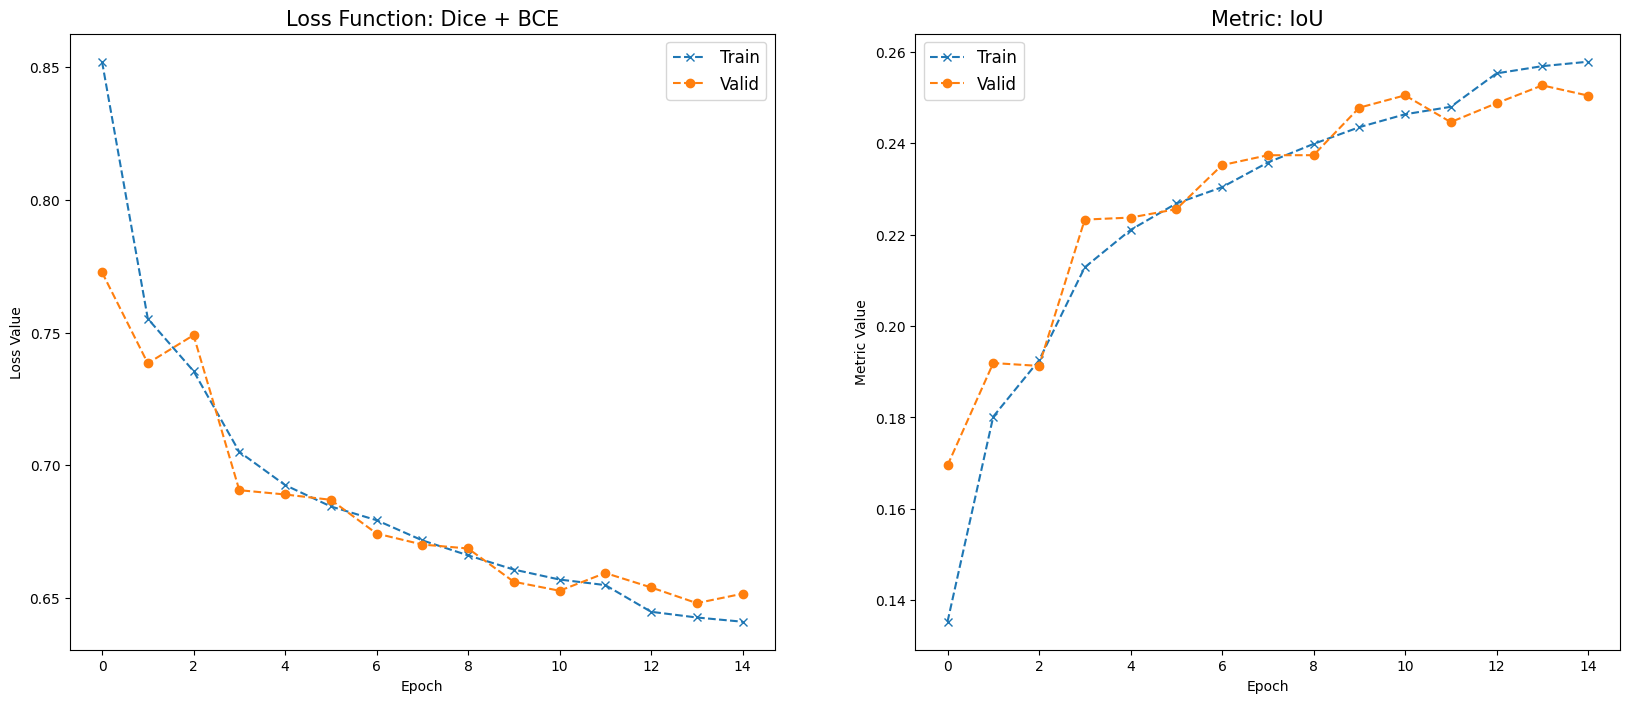

In [3]:
logs = pd.read_csv('../../data/log.txt')
fig, ax = plt.subplots(1, 2, figsize=(20,8)) 
ax[0].set_title('Loss Function: Dice + BCE', size=15)
ax[0].plot(logs['epoch'], logs['train_loss'], 'x--', label='Train')
ax[0].plot(logs['epoch'], logs['valid_loss'], 'o--', label='Valid')
ax[0].set_xlabel('Epoch', fontsize=10)
ax[0].set_ylabel('Loss Value', fontsize=10)
ax[0].legend(fontsize=12)
ax[1].set_title('Metric: IoU', size=15)
ax[1].plot(logs['epoch'], logs['train_metric'], 'x--', label='Train')
ax[1].plot(logs['epoch'], logs['valid_metric'], 'o--', label='Valid')
ax[1].set_xlabel('Epoch', size=10)
ax[1].set_ylabel('Metric Value', size=10)
ax[1].legend(fontsize=12)

### Model

In [4]:
weights = torch.load('../../data/model.pt', map_location='cpu')
weights = weights['model_state_dict']
MODEL = Model()
MODEL.load_state_dict(weights)
MODEL = MODEL.eval()

### Images

In [5]:
def transform(image, label):
    image = cv2.imread(image)
    label = cv2.imread(label)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = []
    transform.append(A.RandomCrop(width=720, height=720))
    transform.append(A.PadIfNeeded(min_height=736, min_width=736, value=255))
    transform = A.Compose(transform)
    output = transform(image=image, mask=label)
    image, label = output['image'], output['mask']
    orig = image.copy()
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    transform = []
    transform.append(transforms.ToTensor())
    transform.append(transforms.Normalize(mean, std))
    transform = transforms.Compose(transform)
    image = transform(image)
    label = label.min(axis=-1)
    label = (np.array(label) != 255).astype(float)
    label = torch.from_numpy(label).squeeze()
    return orig, image, label

In [6]:
DATA = pd.read_csv('../../data/valid.csv')
DATA['image'] = DATA['image'].map(lambda x : x.replace('.jpg',''))
DATA = DATA['image'].tolist()

### Visualize

In [7]:
def visualize(index):
    global DATA, MODEL
    image = '../../data/images/valid/' + DATA[index] + '.jpg'
    label = '../../data/labels/valid/' + DATA[index] + '.png'
    orig, image, label = transform(image, label)
    pred = MODEL(image.unsqueeze(0)).squeeze().data.numpy()
    pred =  1/(1 + np.exp(-pred))
    fig, ax = plt.subplots(1, 3, figsize=(20,8))
    ax[0].imshow(orig)
    ax[1].imshow(label)
    ax[2].imshow(pred)
    ax[0].set_title(f'Image')
    ax[1].set_title(f'Label')
    ax[2].set_title(f'Prediction')
    plt.suptitle(DATA[index], fontsize=16)
    plt.show()
    return None

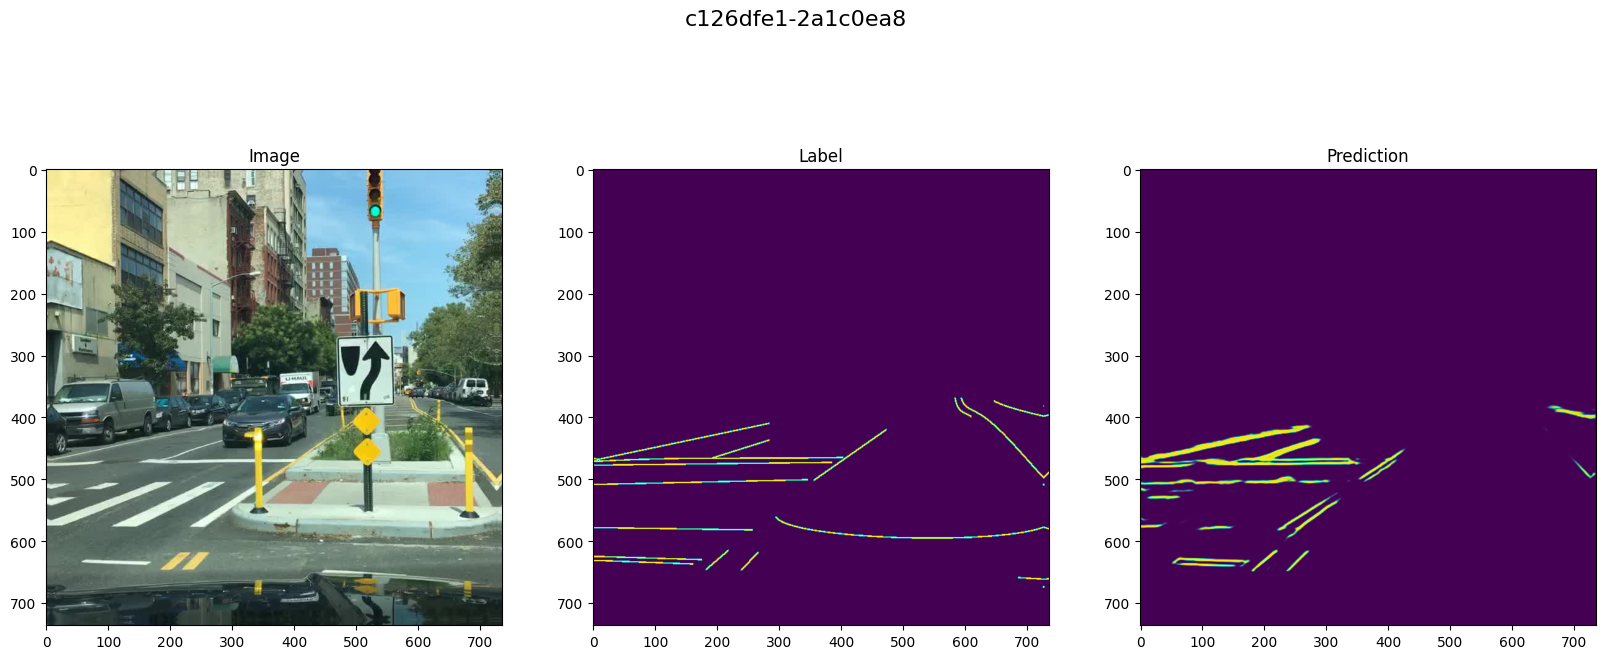

In [8]:
visualize(2)

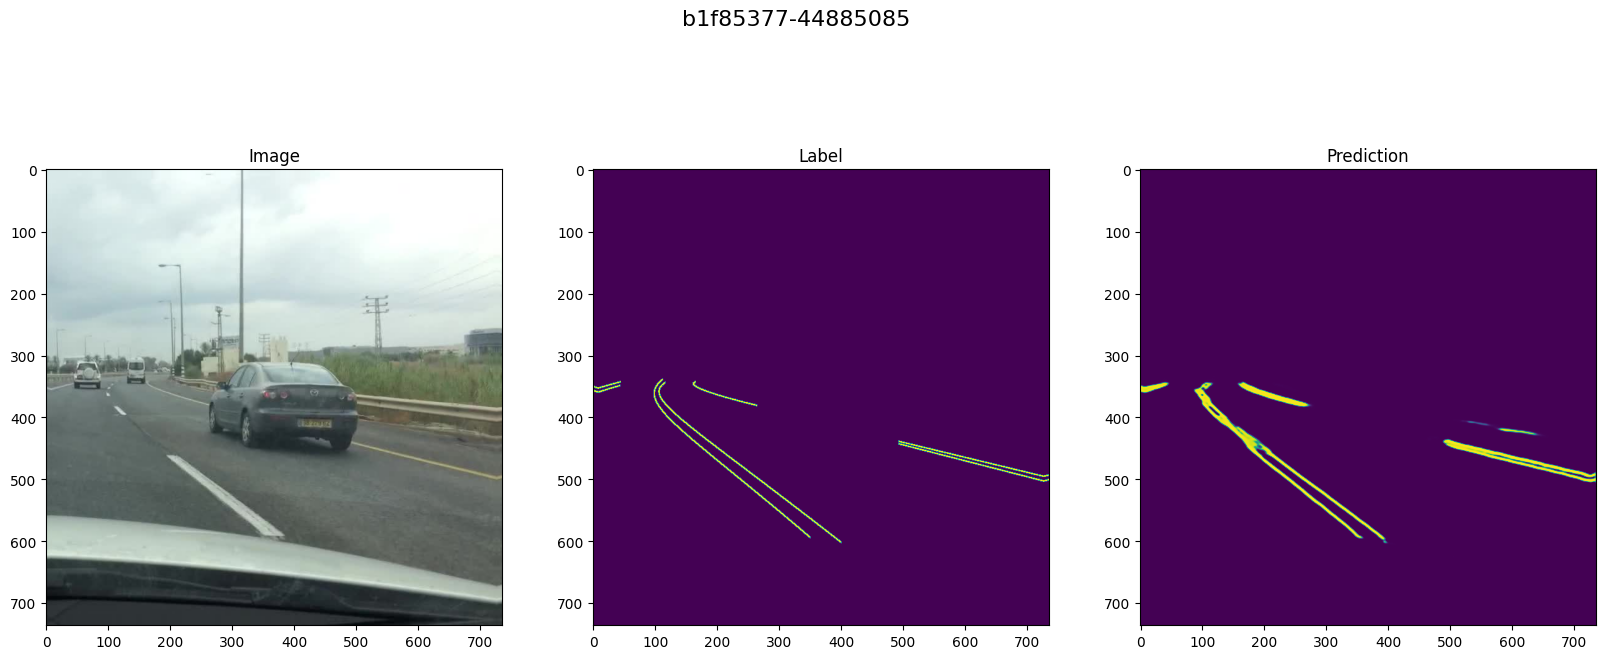

In [9]:
visualize(5)

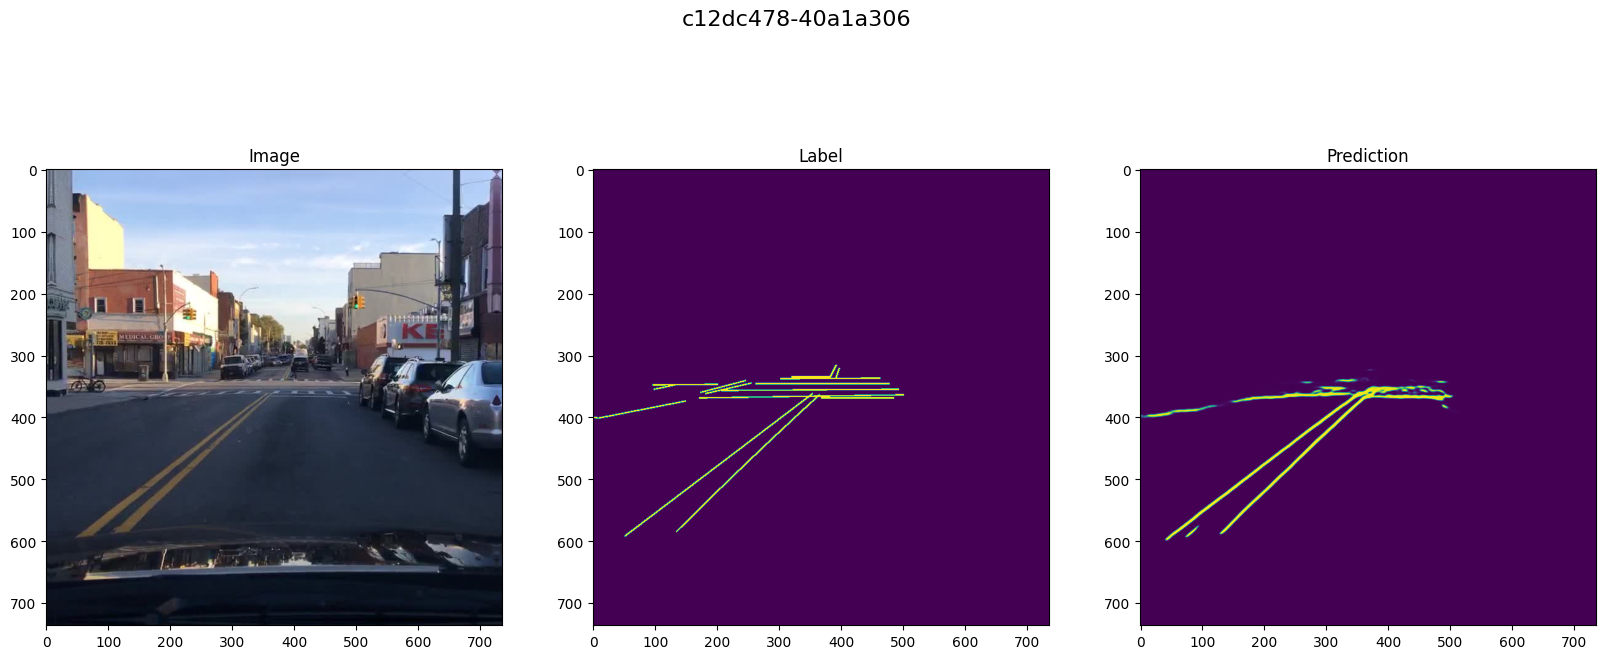

In [10]:
visualize(20)